Contains French -> English hook, KDE summary statistics, effects of French neuron ablations/activations on loss on French and English datasets

## Setup

In [1]:
import haystack_utils
import math
import torch
import numpy as np
import seaborn as sns
from transformer_lens import HookedTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Plotly needs a different renderer for VSCode/Notebooks vs Colab
import plotly.io as pio
pio.renderers.default = "colab"  # "notebook_connected"
device = "cuda" if torch.cuda.is_available() else "cpu"

## Model and data loading

In [2]:
torch.autograd.set_grad_enabled(False)
torch.set_grad_enabled(False)
model = HookedTransformer.from_pretrained("pythia-70m-v0", fold_ln=True, device=device)

Using pad_token, but it is not set yet.


Loaded pretrained model pythia-70m-v0 into HookedTransformer


In [3]:
french = haystack_utils.load_txt_data("kde4_french.txt")
non_french = haystack_utils.load_txt_data("kde4_english.txt")

kde4_french.txt: Loaded 1007 examples with 505 to 5345 characters each.
kde4_english.txt: Loaded 1007 examples with 501 to 5295 characters each.


## Sparse probing to rediscover the french neuron

In [4]:
french_acts = haystack_utils.get_mlp_activations(french, 3, model, -1, context_crop_start=20, context_crop_end=21, mean=False)
non_french_acts = haystack_utils.get_mlp_activations(non_french, 3, model, -1, context_crop_start=20, context_crop_end=21, mean=False)

# Balanced dataset of activations on french and non-french data
smaller_size = min(len(french_acts), len(non_french_acts))
A = torch.concat((french_acts[:smaller_size], non_french_acts[:smaller_size]), dim=0).cpu().numpy()
y = np.array([1]*smaller_size + [0]*smaller_size)

print(A.shape, y.shape)

  0%|          | 0/1007 [00:00<?, ?it/s]

  0%|          | 0/1007 [00:00<?, ?it/s]

(2014, 2048) (2014,)


In [5]:
def get_important_neurons(A_train: np.ndarray, y_train: np.ndarray, k: int):
    # score each activation dimension by the difference between the means of
    # the classes 0 and 1
    A_train, y_train = torch.Tensor(A_train), torch.Tensor(y_train)
    class_0_mean = A_train[y_train == 0].mean(dim=0)
    class_1_mean = A_train[y_train == 1].mean(dim=0)
    scores = (class_1_mean - class_0_mean).abs()
    top_k_scores, top_k_indices = torch.topk(scores, k)
    return top_k_indices, top_k_scores

In [6]:
# Get top classification neurons in A using class labels y
k = 10
test_accs = []
train_accs = []
for i in range(1):
    A_train, A_test, y_train, y_test = train_test_split(A, y, test_size=0.1)
    top_k_indices, top_k_scores = get_important_neurons(A_train, y_train, k)
    lr_model = LogisticRegression()
    topk = top_k_indices.cpu().numpy().tolist()
    print(topk)
    A_train = A_train[:, [730, 1856, 1600]]
    A_test = A_test[:, [730, 1856, 1600]]
    lr_model.fit(A_train, y_train)
    test_acc = lr_model.score(A_test, y_test)
    train_acc = lr_model.score(A_train, y_train)
    test_accs.append(test_acc)
    train_accs.append(train_acc)

print(topk)
print(np.mean(train_accs))

[609, 705, 1361, 902, 102, 588, 37, 1715, 1847, 1932]
[609, 705, 1361, 902, 102, 588, 37, 1715, 1847, 1932]
0.6109271523178808


In [7]:
def get_top_individual_neuron_accuracy(k=10, n=5):
  test_accs = np.zeros((n, k))
  train_accs = np.zeros((n, k))
  for i in range(n):
      A_train, A_test, y_train, y_test = train_test_split(A, y, test_size=0.1)
      top_k_indices, top_k_scores = get_important_neurons(A_train, y_train, k)
      lr_model = LogisticRegression()
      topk = top_k_indices.cpu().numpy().tolist()
      for k_index, neuron in enumerate(topk):
          A_train_tmp = A_train[:, [neuron]]
          A_test_tmp = A_test[:, [neuron]]
          lr_model.fit(A_train_tmp, y_train)
          test_acc = lr_model.score(A_test_tmp, y_test)
          train_acc = lr_model.score(A_train_tmp, y_train)
          test_accs[i, k_index] = test_acc
          train_accs[i, k_index] = train_acc
  return train_accs, test_accs, topk


train_accs, test_accs, topk = get_top_individual_neuron_accuracy(n=20, k=50)

In [8]:
print(topk[:10])
print(train_accs.mean(0)[:10])

[609, 705, 902, 1361, 102, 588, 37, 1715, 907, 1847]
[0.93165011 0.67891832 0.76674945 0.68427152 0.86680464 0.65717439
 0.64679912 0.73195364 0.65068985 0.65905077]


/tmp/ipykernel_29746/1142124930.py:2: UserWarning:

FixedFormatter should only be used together with FixedLocator



Text(0.5, 1.0, 'Individual neuron probe accuracy in MLP layer 3')

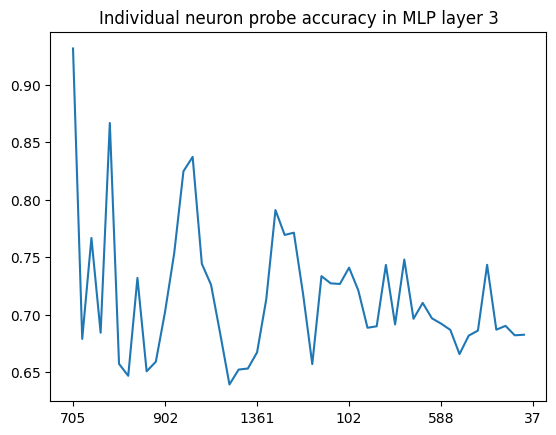

In [9]:
g = sns.lineplot(train_accs.mean(0))
g.set_xticklabels(topk)
g.set_title("Individual neuron probe accuracy in MLP layer 3")

In [10]:
top_k_indices, top_k_scores

(tensor([ 609,  705, 1361,  902,  102,  588,   37, 1715, 1847, 1932]),
 tensor([2.4328, 0.7265, 0.6409, 0.6143, 0.5938, 0.5832, 0.5440, 0.4945, 0.4729,
         0.4663]))

## Test ablation performance

In [11]:
french_activation_L3N609 = french_acts[:, 609]
non_french_activation_L3N609 = non_french_acts[:, 609]
mean_french_activation_L3N609 = french_acts[:, 609].mean(0)
mean_non_french_activation_L3N609 = non_french_acts[:, 609].mean(0)
print("French activation:", mean_french_activation_L3N609.mean(0).item())
print("Non french activation:", mean_non_french_activation_L3N609.mean(0).item())

French activation: 2.3420767784118652
Non french activation: -0.06485679000616074


<Axes: ylabel='Count'>

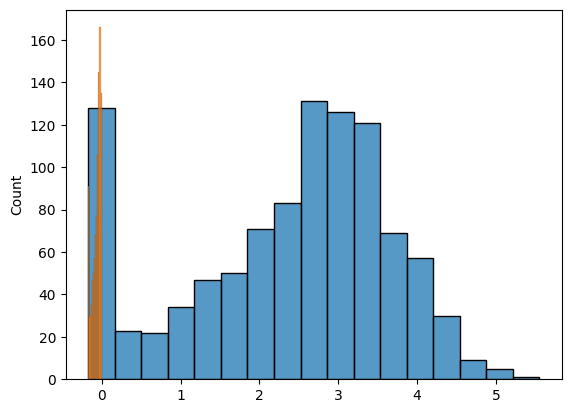

In [12]:
sns.histplot(french_activation_L3N609.cpu().numpy())
sns.histplot(non_french_activation_L3N609.cpu().numpy())

In [13]:
act_label_l3 = f'blocks.3.mlp.hook_post'

In [14]:
def ablate_neuron_hook(value, hook):
  # Shape [batch pos d_mlp]
  #if hook.layer() == 3:
  value[:, :, 609] = mean_non_french_activation_L3N609
  return value

tokens = model.to_tokens(french[500:532])
print(tokens.shape)
original_loss = model(tokens, return_type="loss")
ablated_loss = model.run_with_hooks(tokens, return_type="loss", fwd_hooks=[(act_label_l3, ablate_neuron_hook)])

print(f"Full model loss: {original_loss:.6f}")
print(f"Ablated MLP layer loss: {ablated_loss:.6f}")

torch.Size([32, 521])
Full model loss: 6.603084
Ablated MLP layer loss: 6.703305


In [15]:
# Summary Statistics for KDE dataset on Pythia
# average loss around 3
# loss increase from ablating french neuron around 6%

average_original_loss = 0
average_ablated_loss = 0

min_original_loss = math.inf
paired_ablated_loss = math.inf

for sample in french:
  tokens = model.to_tokens(sample)
  original_loss = model(tokens, return_type="loss")
  ablated_loss = model.run_with_hooks(tokens, return_type="loss", fwd_hooks=[(act_label_l3, ablate_neuron_hook)])

  if (original_loss < min_original_loss):
    min_original_loss = original_loss
    paired_ablated_loss = ablated_loss
    min_original_loss = original_loss

  average_original_loss += original_loss
  average_ablated_loss += ablated_loss

average_original_loss /= len(french)
average_ablated_loss /= len(french)

print(f"Full model loss: {average_original_loss:.6f}")
print(f"Ablated MLP layer loss: {average_ablated_loss:.6f}")
print(f"% increase: {((average_ablated_loss - average_original_loss) / average_original_loss).item() * 100:.6f}")

print(f'{min_original_loss=}')
print(f'{paired_ablated_loss=}')

Full model loss: 3.583874
Ablated MLP layer loss: 3.808673
% increase: 6.272504
min_original_loss=tensor(0.8048, device='cuda:0')
paired_ablated_loss=tensor(0.8037, device='cuda:0')


## Loss from disabling/enabling the neuron on non-French text

In [16]:
def enable_neuron_hook(value, hook):
  # value shape is [batch pos d_mlp]
  value[:, :, 609] = mean_french_activation_L3N609
  return value


def compare_loss_with_ablated(data, ablate_hook):
  average_original_loss = 0
  average_ablated_loss = 0

  for sample in data:
    tokens = model.to_tokens(sample)
    average_original_loss += model(tokens, return_type="loss")
    average_ablated_loss +=  model.run_with_hooks(tokens, return_type="loss", fwd_hooks=[(act_label_l3, ablate_hook)])

  average_original_loss /= len(data)
  average_ablated_loss /= len(data)

  print(f"Full model loss: {average_original_loss:.6f}")
  print(f"Ablated MLP layer loss: {average_ablated_loss:.6f}")
  print(f"% increase: {((average_ablated_loss - average_original_loss) / average_original_loss).item() * 100:.6f}")


# Loss from disabling French neuron on non-French text - if this is high it disproves that the neuron is only relevant to non-French text (although it could be 
# due to French loanwords)
# It's very low
compare_loss_with_ablated(non_french, ablate_neuron_hook)
# Loss from enabling French neuron on non-French text - if this is high it shows that the neuron is influential on its own, not just as part of a circuit
# which we can discover. E.g., there's an unembedding direction which "translates" words and this neuron triggers it.
compare_loss_with_ablated(non_french, enable_neuron_hook)

Full model loss: 3.876772
Ablated MLP layer loss: 3.876870
% increase: 0.002521
Full model loss: 3.876772
Ablated MLP layer loss: 3.955415
% increase: 2.028571


## Modify pythia-70M-v1 language neurons in a failed attempt to get the model to predict German text

In [17]:
from collections import defaultdict
from haystack_utils import load_txt_data, get_mlp_activations

model = HookedTransformer.from_pretrained("EleutherAI/pythia-70m", fold_ln=True, device=device)

# Interesting neurons in Pythia V1, taken from Wes' CSV
english_neurons = [(5, 395), (5, 166), (5, 908), (5, 285), (3, 862), (5, 73), (4, 896), (5, 348), (5, 297), (3, 1204)]
german_neurons = [(4, 482), (5, 1039), (5, 407), (5, 1516), (5, 1336), (4, 326), (5, 250), (3, 669)]

# Get German data and mean neuron activations
german_data = load_txt_data("german_stories.txt")
english_data = load_txt_data("kde4_english.txt")

german_mean_high_activations = defaultdict(torch.Tensor, {
    3: get_mlp_activations(german_data, 3, model, mean=True),  # [2048]
    4: get_mlp_activations(german_data, 4, model, mean=True),
    5: get_mlp_activations(german_data, 5, model, mean=True)
})
german_mean_low_activations = defaultdict(torch.Tensor, {
    3: get_mlp_activations(english_data, 3, model, mean=True),  # [2048]
    4: get_mlp_activations(english_data, 4, model, mean=True),
    5: get_mlp_activations(english_data, 5, model, mean=True)
})
english_mean_high_activations = defaultdict(torch.Tensor, {
    3: get_mlp_activations(english_data, 3, model, mean=True),  # [2048]
    4: get_mlp_activations(english_data, 4, model, mean=True),
    5: get_mlp_activations(english_data, 5, model, mean=True)
})
english_mean_low_activations = defaultdict(torch.Tensor, {
    3: get_mlp_activations(german_data, 3, model, mean=True),  # [2048]
    4: get_mlp_activations(german_data, 4, model, mean=True),
    5: get_mlp_activations(german_data, 5, model, mean=True)
})

english_neurons_by_layer = defaultdict(list)
for item in english_neurons:
    english_neurons_by_layer[item[0]].append(item[1])
german_neurons_by_layer = defaultdict(list)
for item in english_neurons:
    english_neurons_by_layer[item[0]].append(item[1])

Using pad_token, but it is not set yet.


Loaded pretrained model EleutherAI/pythia-70m into HookedTransformer
german_stories.txt: Loaded 20 examples with 243 to 312 characters each.
kde4_english.txt: Loaded 1007 examples with 501 to 5295 characters each.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1007 [00:00<?, ?it/s]

  0%|          | 0/1007 [00:00<?, ?it/s]

  0%|          | 0/1007 [00:00<?, ?it/s]

  0%|          | 0/1007 [00:00<?, ?it/s]

  0%|          | 0/1007 [00:00<?, ?it/s]

  0%|          | 0/1007 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [18]:
def activate_german_hook(value, hook):
    layer = hook.layer()
    german_neurons_for_layer = german_neurons_by_layer[layer]
    english_neurons_for_layer = english_neurons_by_layer[layer]

    value[:, :, german_neurons_for_layer] = german_mean_high_activations[layer][german_neurons_for_layer].cuda()
    value[:, :, english_neurons_for_layer] = english_mean_low_activations[layer][english_neurons_for_layer].cuda()
    return value

def activate_english_hook(value, hook):
    layer = hook.layer()
    german_neurons_for_layer = german_neurons_by_layer[layer]
    english_neurons_for_layer = english_neurons_by_layer[layer]

    value[:, :, german_neurons_for_layer] = german_mean_low_activations[layer][german_neurons_for_layer].cuda()
    value[:, :, english_neurons_for_layer] = english_mean_high_activations[layer][english_neurons_for_layer].cuda()
    return value

# Uses words present in both German and English
german_english_prompt = "Gift. Definition:"
german_english_prompt_2 = "Bank"
tokens = model.to_tokens(german_english_prompt_2).cuda()

name_filter = lambda name: name.endswith("mlp.hook_post")
with model.hooks(fwd_hooks=[(name_filter, activate_german_hook)]):
    predictions = []
    logits, cache = model.run_with_cache(tokens)
    log_probs = logits.log_softmax(dim=-1)
    probs = logits.log_softmax(dim=-1)
    next_token = logits[0, -1].argmax(dim=-1)
    next_char = model.to_string(next_token)
    predictions.append(repr(next_char))

    for i in range(1, 50):
        tokens = torch.cat([tokens, next_token[None, None]], dim=-1)
        logits = model(tokens)
        next_token = logits[0, -1].argmax(dim=-1)
        next_char = model.to_string(next_token)
        predictions.append(next_char)

print("".join(predictions))

# original_loss = model(tokens, return_type="loss")
# ablated_loss = model.run_with_hooks(tokens, return_type="loss", fwd_hooks=[(f'blocks.{layer}.mlp.hook_post', ablate_neuron_hook)])

# with model.hooks(fwd_hooks=[(name_filter, ablate_neuron_hook)]):
#     utils.test_prompt(german_english_prompt, " sdfds", model)
# print(utils.test_prompt(german_english_prompt, " sdfds", model))

' of' India

Bank of India

Bank of India

Bank of India

Bank of India

Bank of India

Bank of India

Bank of India

Bank of India

Bank of India

Bank


## Clean French to English hook

In [43]:
def activate_english_hook(value, hook):
    layer = hook.layer()
    # german_neurons_for_layer = german_neurons_by_layer[layer]
    english_neurons_for_layer = english_neurons_by_layer[layer]

    # value[:, :, german_neurons_for_layer] = german_mean_low_activations[layer][german_neurons_for_layer].cuda()
    value[:, :, english_neurons_for_layer] = english_mean_high_activations[layer][english_neurons_for_layer].cuda()

    if layer == 3:
        value[:, :, 609] = mean_french_activation_L3N609
    return value

# Uses words present in both German and English
german_english_prompt = "Gift. Definition:"
german_english_prompt_2 = "Bank"

def generate_text(tokens, model, fwd_hooks=[]):
    prompt_string = "".join(model.to_string(tokens))
    with model.hooks(fwd_hooks=fwd_hooks):
        predictions = []
        logits = model(tokens)
        next_token = logits[0, -1].argmax(dim=-1)
        next_char = model.to_string(next_token)
        predictions.append(next_char)

        for _ in range(1, 20):
            tokens = torch.cat([tokens, next_token[None, None]], dim=-1)
            logits = model(tokens)
            next_token = logits[0, -1].argmax(dim=-1)
            next_char = model.to_string(next_token)
            predictions.append(next_char)

        return prompt_string + "".join(predictions)

french_prompt = "Je suis un chat. Bonjour"
tokens = model.to_tokens(french_prompt).cuda()
tokens = tokens[:, :-1] # remove the jour token

print("Baseline prediction on French prompt:")
print(generate_text(tokens, model))
print("\nWith English neurons activated:")
print(generate_text(tokens, model, fwd_hooks=[(lambda name: name.endswith("mlp.hook_post"), activate_english_hook)]))


french_prompt = "Quoique ce détail ne touche en aucune manière au fond même de ce que nous avons à raconter"
tokens = model.to_tokens(french_prompt).cuda()

print("\nBaseline prediction on French prompt:")
print(generate_text(tokens, model))
print("\nWith English neurons activated:")
print(generate_text(tokens, model, fwd_hooks=[(lambda name: name.endswith("mlp.hook_post"), activate_english_hook)]))

Baseline prediction on French prompt:
<|endoftext|>Je suis un chat. Bonjour, je suis un chatte, je suis un chatte, je suis un chatte,

With English neurons activated:


<|endoftext|>Je suis un chat. Bonus: I’m not going to be a chatty chatty chatty chatty chatty

Baseline prediction on French prompt:
<|endoftext|>Quoique ce détail ne touche en aucune manière au fond même de ce que nous avons à raconter les trois ans de la première fois.

Le détail de la première fois,

With English neurons activated:
<|endoftext|>Quoique ce détail ne touche en aucune manière au fond même de ce que nous avons à raconter les questions about the nature of the human race.

On a question about the nature of the
